In [1]:
import xarray as xr
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import scipy.signal as signal

import cartopy.crs as ccrs
import matplotlib.path as mpath

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [4]:
fpath = {'CM4': '/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/',
        'ESM4': '/archive/Katherine.Turner/fre/FMS2021.02_mom6_ESM4_v1.0.3/ESM4_piControl_D/gfdl.ncrc5-intel23-prod-openmp/'}

In [13]:
mod = 'ESM4'

## 1. Nino34 Index

In [14]:
ds = xr.open_mfdataset(f"{fpath[mod]}pp/ocean_monthly/ts/monthly/5yr/*tos.nc", use_cftime=True)
static = xr.open_dataset(f"{fpath[mod]}pp/ocean_monthly/ocean_monthly.static.nc")

In [15]:
idx_nino34 = (static.geolat >= -5) & (static.geolat <= 5) & (static.geolon >= -170) & (static.geolon <= -120)

In [16]:
tos_weighted = ds.tos.where(idx_nino34).weighted(static.areacello.where(idx_nino34).fillna(0))

In [17]:
sst_nino34 = tos_weighted.mean(('xh', 'yh'))

In [18]:
sst_nino34 = sst_nino34.load()

In [19]:
sst_nino34.to_dataset(name='nino34').to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_nino34.nc')

In [26]:
mu = sst_nino34.mean()
sigma = sst_nino34.std()

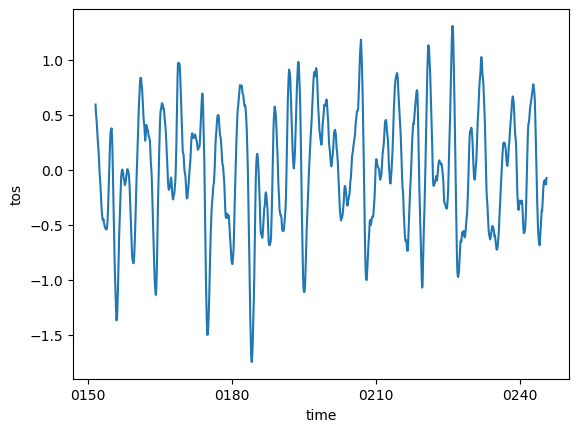

In [33]:
((sst_nino34 - mu)/sigma).rolling(time=12, center=True).mean().plot()

In [43]:
sst_nino34_DJF = sst_nino34.resample(time='QS-DEC').mean()[::4]

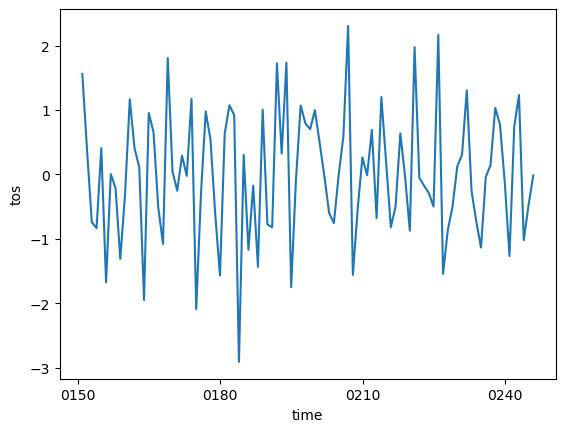

In [45]:
((sst_nino34_DJF - sst_nino34_DJF.mean())/sst_nino34_DJF.std()).plot()

In [65]:
NINO = (sst_nino34_DJF - sst_nino34_DJF.mean())/sst_nino34_DJF.std()
r = np.corrcoef(storm_counts_summer[mod], NINO[1:-1].data)
r[0,1]

In [68]:
n = 94

# Compute t-statistic
t_stat = r * np.sqrt((n - 2) / (1 - r**2))

# Compute two-tailed p-value
pval = xr.apply_ufunc(
    lambda x: 2 * t.sf(np.abs(x), df=n - 2),
    t_stat,
    input_core_dims=[[]],
    output_core_dims=[[]],
    vectorize=True,
    dask="allowed"
)

pval

/vftmp/Katherine.Turner/pid1869899/ipykernel_1879050/12293615.py:4: RuntimeWarning: divide by zero encountered in divide
  t_stat = r * np.sqrt((n - 2) / (1 - r**2))


array([[0.        , 0.03154305],
       [0.03154305, 0.        ]])

## 2. Comparison with zonal winds

In [93]:
ds_u = xr.open_mfdataset(f"{fpath[mod]}pp/atmos_cmip_2deg_daily_3D/ts/daily/5yr/*ua.nc", use_cftime=True)
ds_v = xr.open_mfdataset(f"{fpath[mod]}pp/atmos_cmip_2deg_daily_3D/ts/daily/5yr/*va.nc", use_cftime=True)

In [94]:
static_a = xr.open_dataset(f"{fpath[mod]}pp/atmos_cmip_2deg_daily_3D/atmos_cmip_2deg_daily_3D.static.nc")

In [ ]:
u850 = ds_u.ua.sel(lat=slice(-90,-15), plev19=850e2).load()
v850 = ds_v.va.sel(lat=slice(-90,-15), plev19=850e2).load()

In [149]:
ua = ds_u.ua.mean(dim='lon')
ua = ua.assign_coords(p = ua.plev19 * 1e-2)

ua_djf = ua.sel(lat=slice(-90,0)).resample(time='QS-DEC').mean()[::4,:,:]
ua_djf_anom = ua_djf - ua_djf.mean(dim='time')

rho = xr.corr(NINO, ua_djf_anom, dim="time")

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


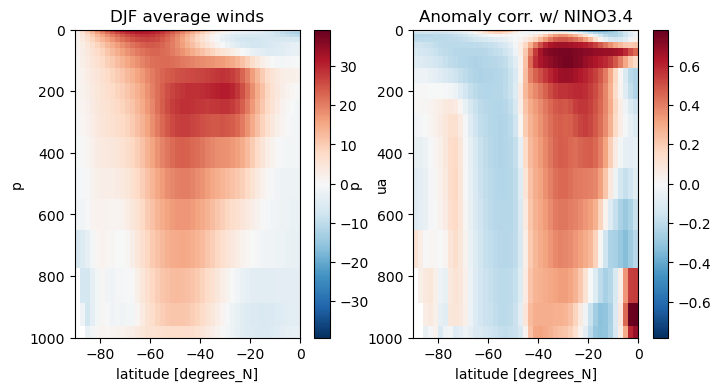

In [152]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ua.mean(dim='time').plot(ax=axs[0], y='p')
axs[0].set_title('DJF average winds')

rho.plot(ax=axs[1], y='p')
axs[1].set_title('Anomaly corr. w/ NINO3.4')

for i in range(2):
    axs[i].set_ylim([1000, 0])
    axs[i].set_xlim([-90, 0])

In [107]:
lat_weights = np.sqrt(np.cos(np.deg2rad(ua_djf.lat.data)))

In [108]:
dz = np.sqrt(ua_djf.plev19[:-1].data - ua_djf.plev19[1:].data)

In [109]:
combined_weights = dz[:, np.newaxis] * lat_weights[np.newaxis, :]

In [111]:
np.shape(combined_weights)

(18, 45)

In [116]:
ua_djf_2 = ua_djf[:,:-1,:].compute()

In [179]:
solver = Eof(ua_djf_2, weights=combined_weights)

eof = solver.eofs()
pcs = solver.pcs()
vf = solver.varianceFraction()

(100000.0, 10000.0)

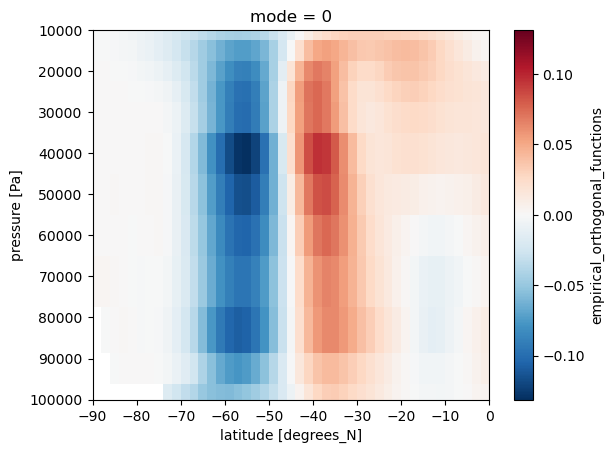

In [136]:
eof[0,:,:].plot()
plt.ylim([100000,10000])

(100000.0, 10000.0)

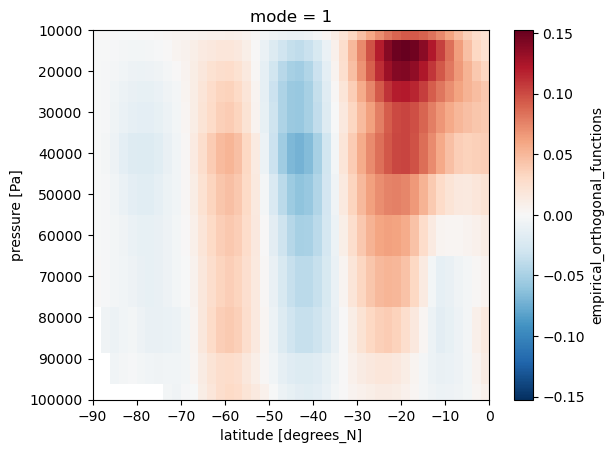

In [137]:
eof[1,:,:].plot()
plt.ylim([100000,10000])

## 3. What about EKE?

In [155]:
eke = (ds_u.ua**2 + ds_v.va**2)**0.5

In [156]:
eke_djf = eke.resample(time='QS-DEC').mean().sel(lat=slice(-90,0))
eke_djf = eke_djf[::4,:,:].compute()

In [162]:
solver = Eof(eke_djf[:,:-1,:,:].mean(dim='lon'), weights=combined_weights)

In [163]:
eof = solver.eofs()
pcs = solver.pcs()

(100000.0, 10000.0)

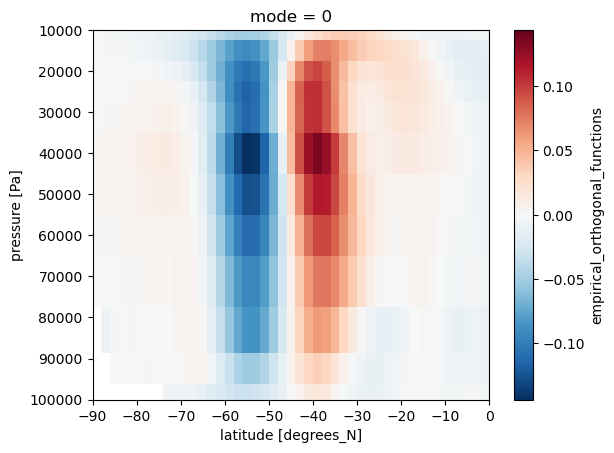

In [177]:
eof[0,:,:].plot()
plt.ylim([100000,10000])

In [176]:
vf = solver.varianceFraction()
vf[:3]

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.625627  , 0.12277312, 0.06409533], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

## 4. Comparing fraction of variance in high frequencies

In [188]:
ds_slp = xr.open_mfdataset('/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148_rerun/gfdl.ncrc5-intel22-prod-openmp/pp/atmos/ts/6hr/5yr/*slp.nc', use_cftime=True)

ds_out = ds_slp.chunk({'time':36500, 'lat':45, 'lon':48})
ds_out.to_zarr('/xtmp/Katherine.Turner/work/storm_timeseries/CM_slp')

ds = xr.open_zarr(f'/xtmp/Katherine.Turner/work/storm_timeseries/CM_slp')
ts_shape = ds.slp.shape

filtered = np.ones(shape=ts_shape)*np.nan
sos = signal.butter(4, 0.1, 'highpass', fs=4, output='sos')

for i in range(80,90):
    for j in range(288):
        sig = ds.slp[:,i,j].data
        filtered[:,i,j] = signal.sosfilt(sos, sig)
    if i%10 == 0:
        print(i)

ds_out = xr.Dataset(
    data_vars=dict(
        slp_bp_1d_10d=(["time", "lat", "lon"], filtered[:,:90,:]),
    ),
    coords=dict(
        lon=("lon", ds.lon.data),
        lat=("lat", ds.lat[:90].data),
        time=ds.time.data,
    ),
    attrs=dict(description=f"Bandpass-filtered slp in CM4"),
)

ds_out = ds_out.chunk({'time':34675, 'lon':48})
ds_out.to_zarr(f'/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp_bandpassed_syn')

In [5]:
ds = xr.open_zarr(f'/xtmp/Katherine.Turner/work/storm_timeseries/CM_slp')
ds_bp = xr.open_zarr(f'/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp_bandpassed_syn')

In [8]:
ds_SH = (1e-2*ds.slp[20*4:-20*4,:,:]).resample(time='QS-DEC').var()
ds_SH = ds_SH.compute()

ds_SH_bp = (1e-2*ds_bp.slp_bp_1d_10d[20*4:-20*4,:,:]).resample(time='QS-DEC').var()
ds_SH_bp = ds_SH_bp.compute()

In [9]:
hy = np.array(high_years[mod])
ly = np.array(low_years[mod])

idx_hi = ds_SH.time.dt.year.isin(hy-1) & (ds_SH.time.dt.season == 'DJF')
idx_lo = ds_SH.time.dt.year.isin(ly-1) & (ds_SH.time.dt.season == 'DJF')

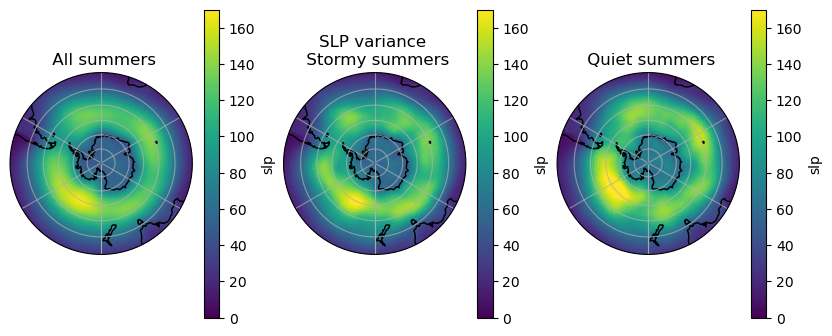

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize = (10,4))

axs = axs.flatten()

ds_SH[::4,:,:].mean(dim='time').plot(ax=axs[0],
                                       transform=ccrs.PlateCarree(),
                                       vmin=0, vmax=170, extend='neither',
                                      )
axs[0].set_title('\n All summers')

ds_SH[idx_hi,:,:].mean(dim='time').plot(ax=axs[1],
                                          transform=ccrs.PlateCarree(),
                                          vmin=0, vmax=170, extend='neither',
                                      )
axs[1].set_title('SLP variance \n Stormy summers')

ds_SH[idx_lo,:,:].mean(dim='time').plot(ax=axs[2],
                                          transform=ccrs.PlateCarree(),
                                          vmin=0, vmax=170, extend='neither',
                                      )

axs[2].set_title('\n Quiet summers')

for i in range(3):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig('/home/Katherine.Turner/SLPvar_summer_CM4.png', dpi=100, format='png')

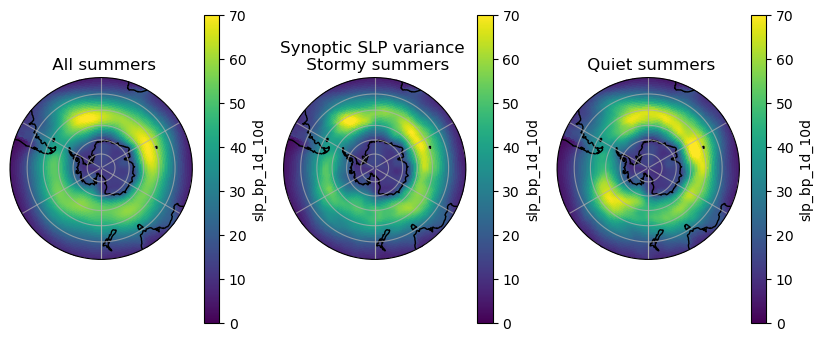

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize = (10,4))

axs = axs.flatten()

ds_SH_bp[::4,:,:].mean(dim='time').plot(ax=axs[0],
                                       transform=ccrs.PlateCarree(),
                                       vmin=0, vmax=70, extend='neither',
                                      )
axs[0].set_title('\n All summers')

ds_SH_bp[idx_hi,:,:].mean(dim='time').plot(ax=axs[1],
                                          transform=ccrs.PlateCarree(),
                                          vmin=0, vmax=70, extend='neither',
                                      )
axs[1].set_title('Synoptic SLP variance \n Stormy summers')

ds_SH_bp[idx_lo,:,:].mean(dim='time').plot(ax=axs[2],
                                          transform=ccrs.PlateCarree(),
                                          vmin=0, vmax=70, extend='neither',
                                      )

axs[2].set_title('\n Quiet summers')

for i in range(3):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig('/home/Katherine.Turner/SLPsynvar_summer_CM4.png', dpi=100, format='png')

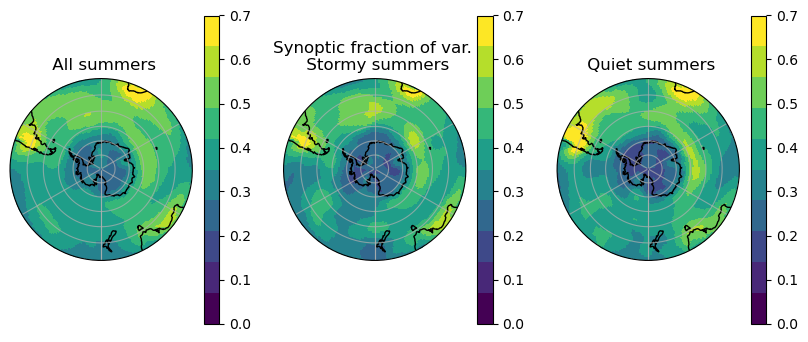

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize = (10,4))

axs = axs.flatten()

(ds_SH_bp[::4,:,:]/ds_SH[::4,:,:]).mean(dim='time').plot(ax=axs[0],
                                                             transform=ccrs.PlateCarree(),
                                                             vmin=0, vmax=.7, 
                                                             extend='neither',
                                                             cmap=plt.get_cmap('viridis', 10))
axs[0].set_title('\n All summers')

(ds_SH_bp[idx_hi,:,:]/ds_SH[idx_hi,:,:]).mean(dim='time').plot(ax=axs[1],
                                                                   transform=ccrs.PlateCarree(),
                                                                   vmin=0, vmax=.7, 
                                                                   extend='neither',
                                                                   cmap=plt.get_cmap('viridis', 10))

axs[1].set_title('Synoptic fraction of var. \n Stormy summers')
(ds_SH_bp[idx_lo,:,:]/ds_SH[idx_lo,:,:]).mean(dim='time').plot(ax=axs[2],
                                                                   transform=ccrs.PlateCarree(),
                                                                   vmin=0, vmax=.7, 
                                                                   extend='neither',
                                                                   cmap=plt.get_cmap('viridis', 10))
axs[2].set_title('\n Quiet summers')

for i in range(3):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig('/home/Katherine.Turner/SLPfracvar_summer_CM4.png', dpi=100, format='png')

In [249]:
d_hi = (slp_bp_djf[idx_hi,:,:]/slp_djf[idx_hi,:,:]).mean(dim='time') - (slp_bp_djf[::4,:,:]/slp_djf[::4,:,:]).mean(dim='time')
d_lo = (slp_bp_djf[idx_lo,:,:]/slp_djf[idx_lo,:,:]).mean(dim='time') - (slp_bp_djf[::4,:,:]/slp_djf[::4,:,:]).mean(dim='time')

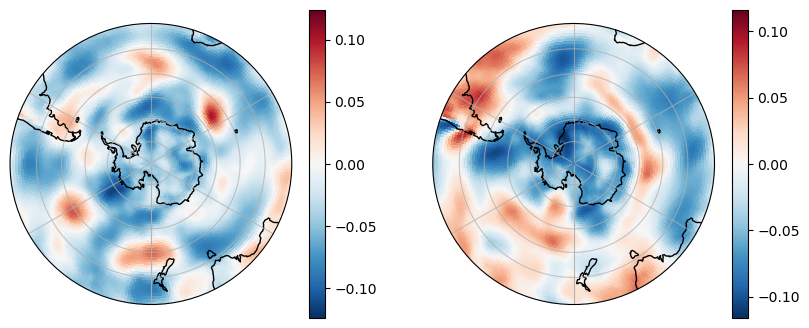

In [250]:
fig, axs = plt.subplots(ncols=2, nrows=1, 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize = (10,4))

d_hi.plot(ax=axs[0], 
          transform=ccrs.PlateCarree(), 
                                                             #vmin=0, vmax=.7, cmap=plt.get_cmap('viridis', 10)
                                                                                                         )
d_lo.plot(ax=axs[1], 
          transform=ccrs.PlateCarree(), 
                                                             #vmin=0, vmax=.7, cmap=plt.get_cmap('viridis', 10)
                                                                                                         )


for i in range(2):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
#plt.savefig('/home/Katherine.Turner/Figures/ESM4_stormywint_toscomp.png', format='png', dpi=100)